# BLOCK 5: Clustering & Pattern Discovery (25 minutes)

## Clustering Fundamentals and Applications (5 minutes)

### What is Clustering?

**Clustering** is an unsupervised machine learning technique that groups similar data points together without prior knowledge of group labels. It discovers hidden patterns and structures in data by identifying natural groupings.

### Key Clustering Concepts:

1. **Similarity/Distance**: How we measure closeness between data points
2. **Centroids**: Representative points of clusters
3. **Intracluster Similarity**: Points within clusters are similar
4. **Intercluster Dissimilarity**: Points between clusters are different
5. **Cluster Validation**: Measuring clustering quality

### Clustering Applications in Oil Well Monitoring:

- **Operational States**: Identify distinct operational patterns
- **Sensor Grouping**: Find sensors that behave similarly
- **Fault Pattern Discovery**: Discover unknown fault signatures
- **Predictive Maintenance**: Group similar degradation patterns
- **Process Optimization**: Identify optimal operating conditions

### Our Clustering Analysis Approach:

**Data Strategy**: Using **complete 3W dataset** with 500-point time series
- **Complete Data Source**: Direct from 3W dataset folders (not windowed)
- **Fixed Length**: Resize each time series to exactly 500 points
- **Class Focus**: **Analyzing available fault classes** for focused comparison
- **Feature Matrix**: Each row = one 500-point time series per sensor

### Clustering Methods We'll Explore:

1. **K-means**: Centroid-based partitioning with elbow method & silhouette analysis
2. **Mean Shift**: Density-based clustering finding modes
3. **DBSCAN**: Density-based clustering with noise detection
4. **Evaluation**: Cluster quality metrics and interpretability

### Why Clustering Matters for 3W Dataset:
- **Pattern Discovery**: Find unknown operational patterns among selected fault types
- **Data Understanding**: Reveal natural groupings in sensor data
- **Dimensionality Analysis**: Understand sensor relationships
- **Fault Discrimination**: Distinguish between different fault types in the dataset
- **Process Knowledge**: Gain understanding of specific oil well failure modes

In [1]:
# ============================================================
# IMPORT LIBRARIES AND SETUP
# ============================================================

print("Setting up Clustering Analysis Environment")
print("=" * 45)

# Import required libraries
import sys
import os
import time
import numpy as np

# Add src to path
sys.path.append("src")

print("Importing clustering utilities...", end=" ")
from src.clustering_utils import ClusteringDataLoader
from src.data_persistence import DataPersistence
from src import config

print("OK")

# Configuration
TARGET_LENGTH = 500  # Fixed length for all time series
MAX_FILES_PER_CLASS = 50  # Limit files per class for manageable analysis
ENABLE_SAMPLING = True  # Enable sampling for faster processing
TARGET_CLASSES = [
    "3",
    "4",
    "8",
]  # Preferred classes to analyze (will adapt if not available)

print(f"\nClustering Configuration:")
print(f"   • Target time series length: {TARGET_LENGTH} points")
print(f"   • Max files per class: {MAX_FILES_PER_CLASS}")
print(f"   • Sampling enabled: {ENABLE_SAMPLING}")
print(f"   • Preferred classes for analysis: {TARGET_CLASSES}")

# Initialize data loader
data_loader = ClusteringDataLoader(
    target_length=TARGET_LENGTH,
    max_files_per_class=MAX_FILES_PER_CLASS,
    enable_sampling=ENABLE_SAMPLING,
)

print("\nSetup complete! Ready to load data.")

Setting up Clustering Analysis Environment
Importing clustering utilities... OK

Clustering Configuration:
   • Target time series length: 500 points
   • Max files per class: 50
   • Sampling enabled: True
   • Preferred classes for analysis: ['3', '4', '8']

Setup complete! Ready to load data.


## 📊 Complete Data Loading Strategy

### Why Use Complete 3W Data for Clustering?

**Different from Previous Notebooks**: Here we use **complete time series** directly from the 3W dataset, not windowed data.

**Key Differences**:
- **Fixed Length**: Resize all time series to exactly 500 points
- **Direct Analysis**: Each complete sensor reading sequence becomes one data point
- **Class Focus**: Analyze specific fault classes (3, 4, 8) for comparison

**Clustering Context**: 
- Each row = one complete oil well operation sequence
- Goal: Discover natural groupings in operational patterns
- Unsupervised: We ignore class labels during clustering

In [2]:
# ============================================================
# LOAD Complete 3W DATASET
# ============================================================

print("Loading Complete 3W Dataset for Clustering Analysis")
print("=" * 55)

try:
    # Initialize data persistence and load complete data
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    complete_data_dir = os.path.join(persistence.cv_splits_dir, "complete")

    if not os.path.exists(complete_data_dir):
        raise FileNotFoundError(
            f"Complete data directory not found: {complete_data_dir}"
        )

    # Load and process data using utility class
    start_time = time.time()
    complete_data_result = data_loader.load_complete_data(
        persistence, complete_data_dir
    )
    load_time = time.time() - start_time

    # Extract and filter data for target classes
    X_original = complete_data_result["X_original"]
    y_labels = complete_data_result["y_labels"]
    file_info = complete_data_result["file_info"]
    fold_used = complete_data_result["fold_used"]

    # Determine available classes and filter for analysis
    available_classes = sorted(np.unique(y_labels))
    existing_classes = [cls for cls in TARGET_CLASSES if cls in available_classes]

    # Use first 3 available classes if target classes don't exist
    if not existing_classes:
        existing_classes = (
            available_classes[:3] if len(available_classes) >= 3 else available_classes
        )
        print(f"⚠️ Target classes not found, using: {existing_classes}")

    # Filter data to selected classes
    class_mask = np.isin(y_labels, existing_classes)
    X_original = X_original[class_mask]
    y_labels = y_labels[class_mask]
    file_info = [file_info[i] for i, mask in enumerate(class_mask) if mask]

    # Display summary
    unique_classes, counts = np.unique(y_labels, return_counts=True)
    print(f"\n✅ Data Loading Complete!")
    print(
        f"   • Total samples: {len(X_original)} | Features: {X_original.shape[1]} | Classes: {len(unique_classes)}"
    )
    print(f"   • Load time: {load_time:.2f}s | Source: {fold_used}")
    print(f"   • Class distribution: {dict(zip(unique_classes, counts))}")

    # Store for subsequent cells
    clustering_data = {
        "X_original": X_original,
        "y_labels": y_labels,
        "file_info": file_info,
        "config": {
            "target_length": TARGET_LENGTH,
            "max_files_per_class": MAX_FILES_PER_CLASS,
            "sampling_enabled": ENABLE_SAMPLING,
            "fold_used": fold_used,
        },
    }

except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    print("💡 Check if 3W dataset is properly extracted and accessible")
    clustering_data = None

Loading Complete 3W Dataset for Clustering Analysis
Loading Complete 3W Dataset for Clustering Analysis
Using fold_1 for clustering analysis

Loading train_data...

Loading test_data...

✅ Data Loading Complete!
   • Total samples: 144 | Features: 1500 | Classes: 3
   • Load time: 0.51s | Source: fold_1
   • Class distribution: {np.str_('3'): np.int64(50), np.str_('4'): np.int64(50), np.str_('8'): np.int64(44)}


## ⚙️ Data Preprocessing for Clustering

### Why Preprocessing Matters for Clustering

**Scaling Issues**: Different sensors have different ranges (pressure vs temperature)
- Without scaling: High-range sensors dominate distance calculations
- Solution: StandardScaler and MinMaxScaler

**Dimensionality Challenge**: 500-point time series = very high dimensions
- Problem: "Curse of dimensionality" affects clustering quality
- Solution: PCA to reduce dimensions while preserving variance

**Multiple Representations**: We prepare several data versions for comparison
- Scaled, normalized, and PCA-reduced variants
- Best clustering method may prefer different preprocessing

In [3]:
# ============================================================
# DATA PREPROCESSING SETUP
# ============================================================

print("Data Preparation for Clustering Analysis")
print("=" * 45)

# Check if we have loaded data from previous cell
if "clustering_data" in locals() and clustering_data is not None:

    # Import preprocessing utilities
    from src.clustering_utils import ClusteringPreprocessor
    import warnings

    warnings.filterwarnings("ignore")

    # Extract complete data
    X_original = clustering_data["X_original"]
    y_labels = clustering_data["y_labels"]
    file_info = clustering_data["file_info"]

    print(f"Complete Data Overview:")
    print(f"   • Data shape: {X_original.shape}")
    print(f"   • Classes: {sorted(np.unique(y_labels))}")
    print(f"   • Total samples: {len(X_original)}")

    # Initialize preprocessor
    preprocessor = ClusteringPreprocessor()

    print("\nPreprocessor initialized. Ready for data preparation.")

else:
    print("No data available for preprocessing")
    print("   Please run the previous cells first to load complete 3W data")
    clustering_data = None

Data Preparation for Clustering Analysis
Complete Data Overview:
   • Data shape: (144, 1500)
   • Classes: [np.str_('3'), np.str_('4'), np.str_('8')]
   • Total samples: 144

Preprocessor initialized. Ready for data preparation.


In [4]:
# ============================================================
# APPLY DATA PREPROCESSING
# ============================================================

if "preprocessor" in locals() and preprocessor is not None:

    print("Applying data preprocessing transformations...")

    # Prepare data with scaling and dimensionality reduction
    processed_data = preprocessor.prepare_data(X_original)

    # Extract processed datasets
    X_scaled = processed_data["X_scaled"]
    X_normalized = processed_data["X_normalized"]
    X_pca_2d = processed_data["X_pca_2d"]
    pca_model = processed_data["pca_model"]
    variance_info = processed_data["variance_info"]

    print(f"\nPreprocessed Data Summary:")
    print(f"   • Original: {X_original.shape}")
    print(f"   • StandardScaled: {X_scaled.shape}")
    print(f"   • MinMax Normalized: {X_normalized.shape}")
    print(f"   • PCA (2D visualization): {X_pca_2d.shape}")

    # Update clustering_data with processed datasets
    clustering_data.update(processed_data)
    clustering_data["y_labels"] = y_labels
    clustering_data["file_info"] = file_info


else:
    print("Preprocessor not available. Please run the previous cell first.")
    clustering_data = None

Applying data preprocessing transformations...
Data Preparation for Clustering Analysis

Preprocessed Data Summary:
   • Original: (144, 1500)
   • StandardScaled: (144, 1500)
   • MinMax Normalized: (144, 1500)
   • PCA (2D visualization): (144, 2)


## 📈 Data Overview and PCA Visualization

### Understanding Your Data Before Clustering

**PCA Visualization**: Shows how much information is captured in lower dimensions
- First few components capture most variance

**Class Distribution**: See how known fault types are distributed
- Remember: clustering ignores these labels
- We'll compare clustering results against known classes later

**Dimensionality Trade-off**: 
- Too many dimensions: clustering becomes unreliable
- Too few dimensions: lose important patterns

Creating Data Overview Visualizations...


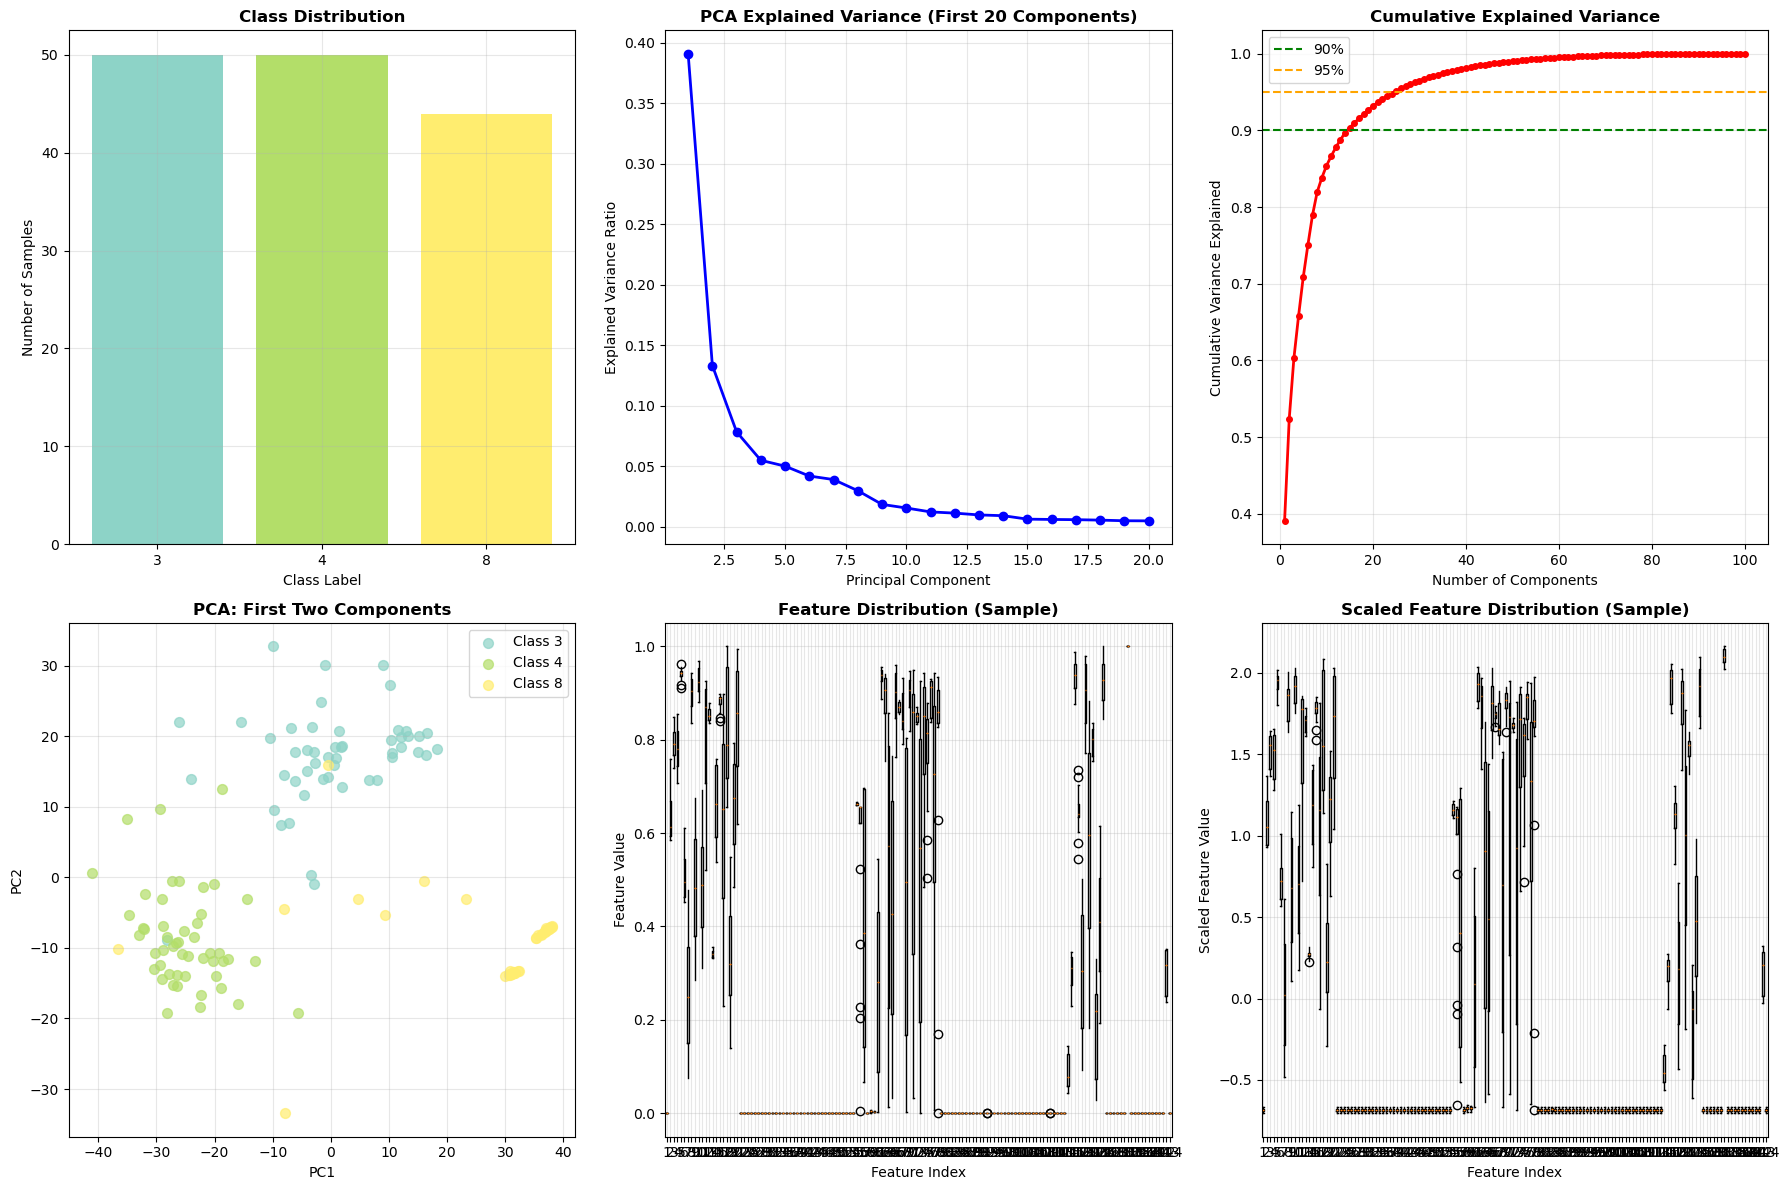

Data overview visualization complete!


In [5]:
# ============================================================
# DATA OVERVIEW VISUALIZATION
# ============================================================

if clustering_data is not None:

    print("Creating Data Overview Visualizations...")

    # Import visualization utilities
    from src.clustering_visualization import ClusteringVisualizer
    import matplotlib.pyplot as plt

    # Create visualizer
    visualizer = ClusteringVisualizer()

    # Create data overview plots
    visualizer.plot_data_overview(
        X_original=clustering_data["X_original"],
        X_scaled=clustering_data["X_scaled"],
        y_labels=clustering_data["y_labels"],
        pca_model=clustering_data["pca_model"],
        X_pca_2d=clustering_data["X_pca_2d"],
    )

    print("Data overview visualization complete!")

else:
    print("No clustering data available for visualization")
    print("   Please run the previous cells first")

## Clustering Theory Deep Dive

### **K-means Clustering Algorithm**

**Mathematical Foundation:**
K-means aims to minimize the Within-Cluster Sum of Squares (WCSS):

$$\text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$$

Where:
- $k$ = number of clusters
- $C_i$ = cluster $i$
- $\mu_i$ = centroid of cluster $i$
- $||x - \mu_i||^2$ = squared Euclidean distance

**Algorithm Steps:**
1. **Initialize**: Randomly place $k$ centroids
2. **Assignment**: Assign each point to nearest centroid
3. **Update**: Recalculate centroids as cluster means
4. **Repeat**: Until convergence (centroids stop moving)

**Key Properties:**
- **Complexity**: $O(nkt)$ where $n$=points, $k$=clusters, $t$=iterations
- **Assumptions**: Spherical clusters, similar sizes, equal variance
- **Convergence**: Guaranteed to local minimum (not global)

**Parameter Selection:**
- **Elbow Method**: Find "elbow" in WCSS vs $k$ plot
- **Silhouette Analysis**: Measure cluster cohesion and separation
- **Gap Statistic**: Compare with random data clustering

**Strengths & Limitations:**
- ✅ **Pros**: Simple, fast, scalable, interpretable
- ❌ **Cons**: Need to specify $k$, sensitive to initialization, assumes spherical clusters

In [6]:
# ============================================================
# K-MEANS CLUSTERING ANALYSIS - SCALED DATA
# ============================================================

print("🚀 K-MEANS CLUSTERING ANALYSIS - Using Scaled Data for Clustering")
print("=" * 70)

# Import the KMeansAnalyzer class
from src.clustering_utils import KMeansAnalyzer

# Initialize analyzer
kmeans_analyzer = KMeansAnalyzer(k_range=range(2, 16))

# Run complete analysis using the extracted method
kmeans_results = kmeans_analyzer.run_kmeans_complete_analysis(
    X_scaled=clustering_data["X_scaled"],
    X_pca_50=clustering_data["X_pca_50"],
    analysis_type="scaled",
    clustering_data=clustering_data,
    visualizer=visualizer,
)

print(f"\n📊 Analysis Summary:")
print(f"   • Data Type: {kmeans_results['data_description']}")
print(f"   • Optimal K: {kmeans_results['optimal_k']}")
print(f"   • Silhouette Score: {kmeans_results['silhouette_score']:.3f}")
print(f"   • Number of Clusters: {kmeans_results['n_clusters']}")
print(f"   • Data Shape: {kmeans_results['clustering_data_shape']}")

# Store results for later use
optimal_k_scaled = kmeans_results["optimal_k"]
best_model = kmeans_results["best_model"]
optimal_labels = kmeans_results["labels"]

🚀 K-MEANS CLUSTERING ANALYSIS - Using Scaled Data for Clustering
🚀 Running Complete K-means Analysis (SCALED)
📊 Step 1: Finding optimal K using Scaled data...
K-means: Finding Optimal K (using SCALED data for clustering)
Testing K=2... OK
Testing K=3... OK
Testing K=4... OK
Testing K=5... OK
Testing K=6... OK
Testing K=7... OK
Testing K=8... OK
Testing K=9... OK
Testing K=10... OK
Testing K=11... OK
Testing K=12... OK
Testing K=13... OK
Testing K=14... OK
Testing K=15... OK
   ✅ Optimal K found: 4
🎯 Step 2: Training final model with K=4...
   ✅ Model trained successfully
   📈 Silhouette Score: 0.374
   📊 Inertia: 104811.91
   🎯 Clusters Found: 4
📊 Step 3: Generating visualizations...
   ⚠️ Visualization warning: ClusteringVisualizer.plot_kmeans_analysis() got an unexpected keyword argument 'clustering_data'
🎉 Complete K-means analysis finished!
------------------------------------------------------------

📊 Analysis Summary:
   • Data Type: Scaled
   • Optimal K: 4
   • Silhouette Scor

## 🔍 K-means Parameter Optimization

### The Critical K Selection Problem

**Challenge**: K-means requires you to specify the number of clusters beforehand
- Too few clusters: Over-generalization, lose important patterns
- Too many clusters: Over-segmentation, noise becomes clusters

**Solution Methods**:
- **Elbow Method**: Find the "bend" in the error reduction curve
- **Silhouette Analysis**: Measure how well-separated clusters are
- **Domain Knowledge**: We expect ~3 clusters (fault classes 3, 4, 8)

**Data Comparison**: Test both scaled and PCA-reduced data
- Different preprocessing may reveal different optimal K values

In [7]:
# ============================================================
# K-MEANS CLUSTERING: FINAL RESULTS AND EVALUATION
# ============================================================

if "kmeans_results" in locals() and kmeans_results is not None:

    # Import evaluation utilities
    from src.clustering_utils import ClusteringEvaluator

    # Create evaluator and run comprehensive K-means evaluation
    evaluator = ClusteringEvaluator()
    kmeans_results = evaluator.evaluate_kmeans_final_results(
        kmeans_results=kmeans_results, clustering_data=clustering_data
    )

else:
    print("K-means results not available")
    print("   Please run the K-means clustering analysis cell first")

K-means Clustering: Final Results and Evaluation
Applying optimal K-means clustering...
   • Method: Scaled
   • Optimal K: 4
   • PCA usage: Visualization only (2D plots)

K-means Performance Evaluation:
   • Silhouette Score: 0.374
   • Adjusted Rand Index: 0.734
   • WCSS: 1.05e+05

Cluster Size Distribution:
   • Cluster 0: 21 samples (14.6%)
   • Cluster 1: 53 samples (36.8%)
   • Cluster 2: 53 samples (36.8%)
   • Cluster 3: 17 samples (11.8%)

K-means clustering analysis complete!
✅ Clustering performed on: SCALED data ((144, 1500))
✅ PCA used for: 2D visualization only


Creating K-means Analysis Visualizations...


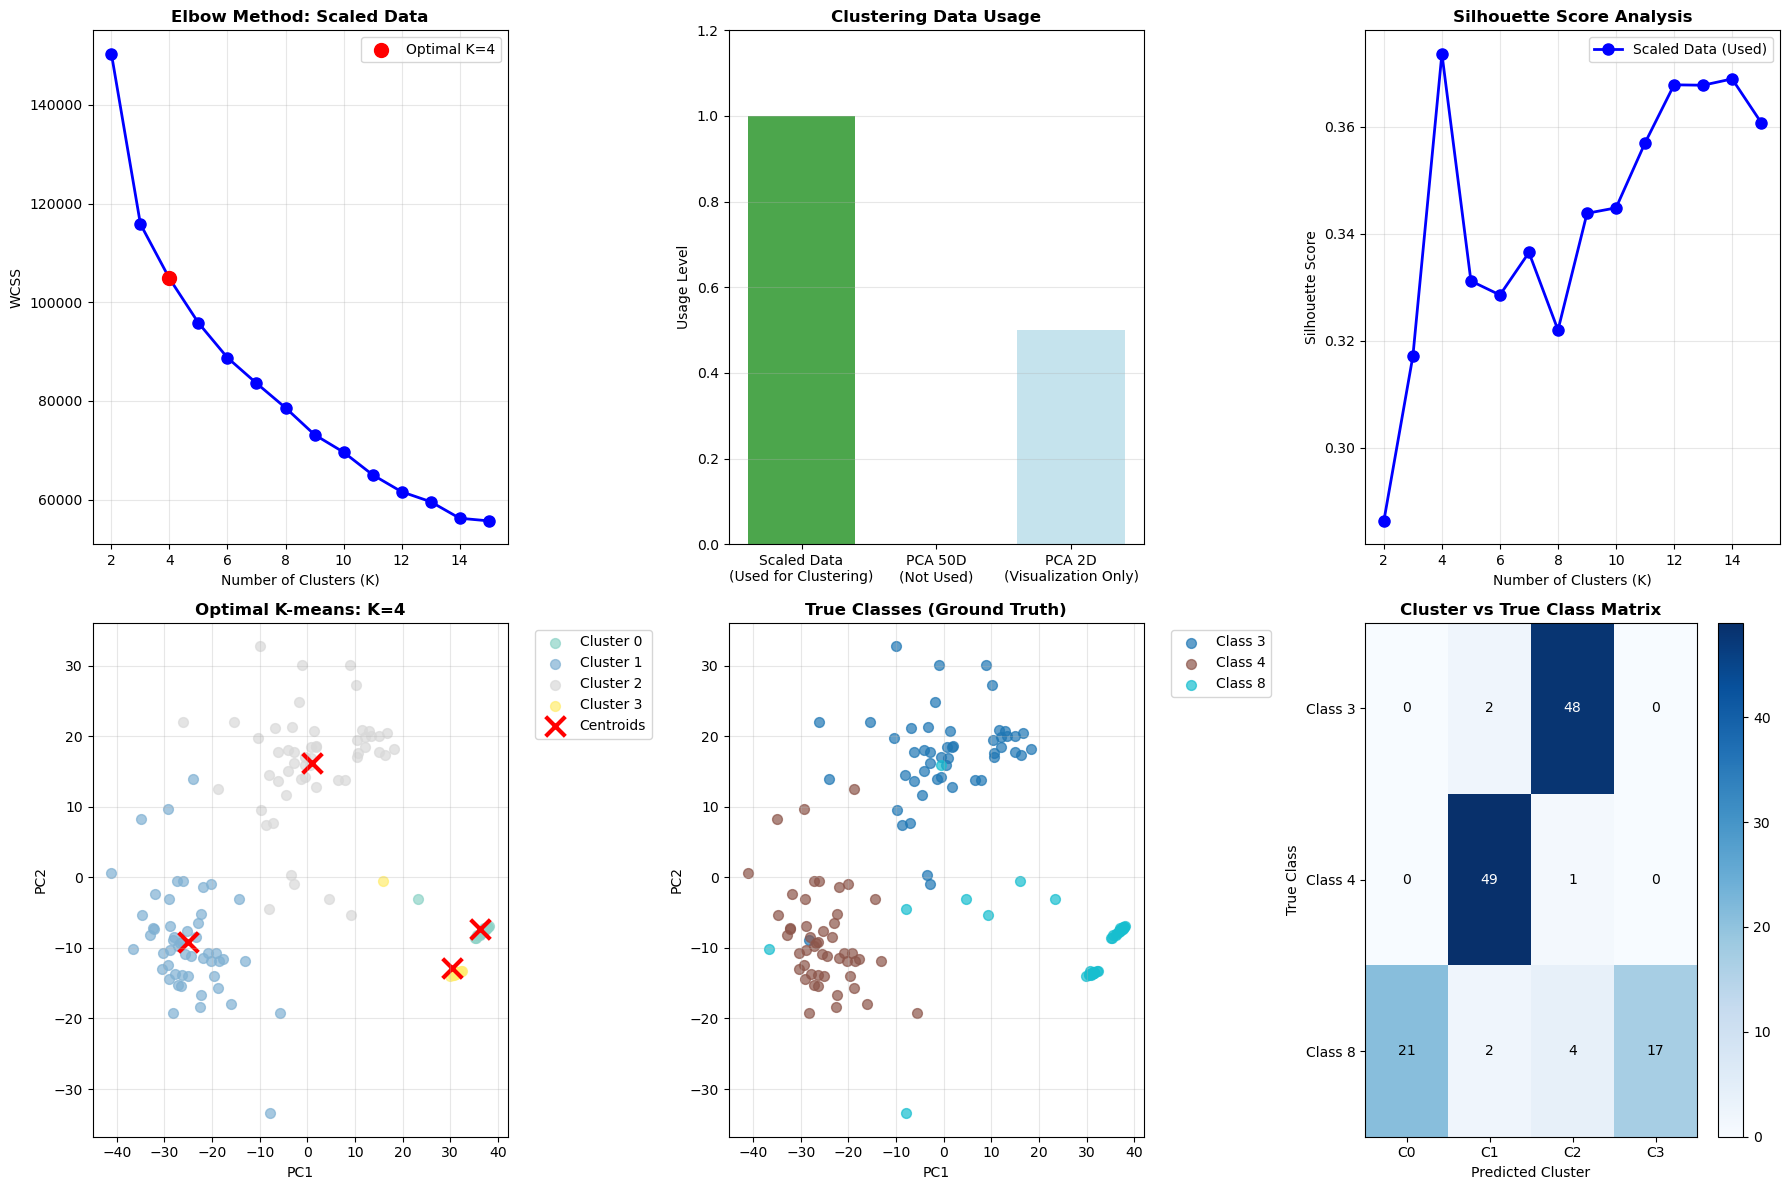

K-means visualization complete!
Note: PCA used only for 2D visualization, clustering performed on scaled data


In [8]:
# ============================================================
# K-MEANS VISUALIZATION
# ============================================================

if "kmeans_results" in locals() and kmeans_results is not None:

    print("Creating K-means Analysis Visualizations...")

    # Create K-means analysis plots
    visualizer.plot_kmeans_analysis(
        k_range=range(2, 16),
        results=kmeans_results["elbow_analysis"],
        optimal_k_scaled=kmeans_results["optimal_k_scaled"],
        optimal_k_pca=None,  # No longer using PCA for clustering
        X_pca_2d=clustering_data["X_pca_2d"],
        optimal_labels=kmeans_results[
            "labels"
        ],  # Fixed: use "labels" instead of "optimal_labels"
        centroids_2d=kmeans_results["centroids_2d"],
        y_true=clustering_data["y_labels"],
        n_clusters=kmeans_results[
            "optimal_k"
        ],  # Fixed: use "optimal_k" instead of "best_k"
    )

    print("K-means visualization complete!")
    print(
        "Note: PCA used only for 2D visualization, clustering performed on scaled data"
    )

else:
    print("K-means results not available for visualization")
    print("   Please run the K-means clustering cells first")

In [9]:
# ============================================================
# K-MEANS CLUSTERING: PCA 50D DATA ANALYSIS
# ============================================================

if clustering_data is not None:
    print("K-means Clustering: PCA 50D Data Analysis")
    print("=" * 45)

    # Extract PCA 50D preprocessed data (if available)
    if "X_pca_50" in clustering_data:
        X_pca_50 = clustering_data["X_pca_50"]
    else:
        # Fallback: create PCA 50D if not available
        from sklearn.decomposition import PCA

        pca_50 = PCA(n_components=50, random_state=42)
        X_pca_50 = pca_50.fit_transform(clustering_data["X_scaled"])
        print("Generated PCA 50D data from scaled data")

    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]

    print(f"K-means Analysis Setup (PCA 50D):")
    print(f"   • PCA 50D data (for clustering): {X_pca_50.shape}")
    print(f"   • PCA 2D (for visualization): {X_pca_2d.shape}")
    print(
        f"   • True classes: {len(np.unique(y_true))} classes {list(np.unique(y_true))}"
    )

    print(f"\n🎯 CLUSTERING STRATEGY (PCA 50D):")
    print(f"   • Using PCA 50D DATA for actual clustering")
    print(f"   • Reduced dimensions: {X_pca_50.shape[1]} features")
    print(f"   • All optimization based on PCA 50D data performance")

    # Initialize K-means analyzer for PCA data
    kmeans_analyzer_pca = KMeansAnalyzer(k_range=range(2, 16))

    print(
        "\nFinding optimal K using elbow method and silhouette analysis on PCA 50D data..."
    )

    # Find optimal K using PCA 50D data only
    results_pca, optimal_k_pca = kmeans_analyzer_pca.find_optimal_k(X_pca_50)

    # Get best model configuration (uses PCA 50D data)
    best_model_info_pca = kmeans_analyzer_pca.get_best_model(
        results_pca, optimal_k_pca, X_pca_50
    )

    print(f"\nOptimal K Selection Results (PCA 50D):")
    print(f"   • Optimal K (PCA 50D data): {optimal_k_pca}")
    print(f"   • Clustering performed on: {best_model_info_pca['best_data_type']}")
    print(f"   • True number of classes: {len(np.unique(y_true))}")
    print(f"   • Dimensions used: {X_pca_50.shape[1]} PCA components")

    # Store results for comparison
    kmeans_optimization_pca = {
        "results": results_pca,
        "optimal_k_pca": optimal_k_pca,
        "best_model_info": best_model_info_pca,
    }

    print("\nK-means parameter optimization (PCA 50D) complete!")

else:
    print("No clustering data available")
    print("   Please run the data preparation cells first")
    kmeans_optimization_pca = None

K-means Clustering: PCA 50D Data Analysis
K-means Analysis Setup (PCA 50D):
   • PCA 50D data (for clustering): (144, 50)
   • PCA 2D (for visualization): (144, 2)
   • True classes: 3 classes [np.str_('3'), np.str_('4'), np.str_('8')]

🎯 CLUSTERING STRATEGY (PCA 50D):
   • Using PCA 50D DATA for actual clustering
   • Reduced dimensions: 50 features
   • All optimization based on PCA 50D data performance

Finding optimal K using elbow method and silhouette analysis on PCA 50D data...
K-means: Finding Optimal K (using SCALED data for clustering)
Testing K=2... OK
Testing K=3... OK
Testing K=4... OK
Testing K=5... OK
Testing K=6... OK
Testing K=7... OK
Testing K=8... OK
Testing K=9... OK
Testing K=10... OK
Testing K=11... OK
Testing K=12... OK
Testing K=13... OK
Testing K=14... OK
Testing K=15... OK

Optimal K Selection Results (PCA 50D):
   • Optimal K (PCA 50D data): 13
   • Clustering performed on: Scaled Data
   • True number of classes: 3
   • Dimensions used: 50 PCA components

K-

In [10]:
# ============================================================
# K-MEANS CLUSTERING: PCA 50D FINAL RESULTS AND EVALUATION
# ============================================================

if "kmeans_optimization_pca" in locals() and kmeans_optimization_pca is not None:

    # Create evaluator and run comprehensive K-means PCA evaluation
    kmeans_results_pca = evaluator.evaluate_kmeans_pca_final_results(
        kmeans_optimization_pca=kmeans_optimization_pca,
        clustering_data=clustering_data,
        scaled_kmeans_results=kmeans_results if "kmeans_results" in locals() else None,
    )

else:
    print("K-means PCA optimization results not available")
    print("   Please run the K-means PCA parameter optimization cell first")
    kmeans_results_pca = None

K-means Clustering: PCA 50D Final Results and Evaluation
Applying optimal K-means clustering (PCA 50D)...
   • Method: Scaled Data (PCA 50D data)
   • Optimal K: 13
   • Feature dimensions: 50 PCA components

K-means Performance Evaluation (PCA 50D):
   • Silhouette Score: 0.380
   • Adjusted Rand Index: 0.306
   • WCSS: 5.74e+04

Cluster Size Distribution (PCA 50D):
   • Cluster 0: 11 samples (7.6%)
   • Cluster 1: 5 samples (3.5%)
   • Cluster 2: 16 samples (11.1%)
   • Cluster 3: 19 samples (13.2%)
   • Cluster 4: 9 samples (6.2%)
   • Cluster 5: 4 samples (2.8%)
   • Cluster 6: 21 samples (14.6%)
   • Cluster 7: 17 samples (11.8%)
   • Cluster 8: 9 samples (6.2%)
   • Cluster 9: 14 samples (9.7%)
   • Cluster 10: 4 samples (2.8%)
   • Cluster 11: 8 samples (5.6%)
   • Cluster 12: 7 samples (4.9%)

K-means clustering analysis (PCA 50D) complete!
✅ Clustering performed on: PCA 50D data ((144, 50))
✅ Centroids available in: 2D PCA space for visualization

📊 COMPARISON: Scaled Data vs 

Creating K-means PCA 50D Analysis Visualizations...


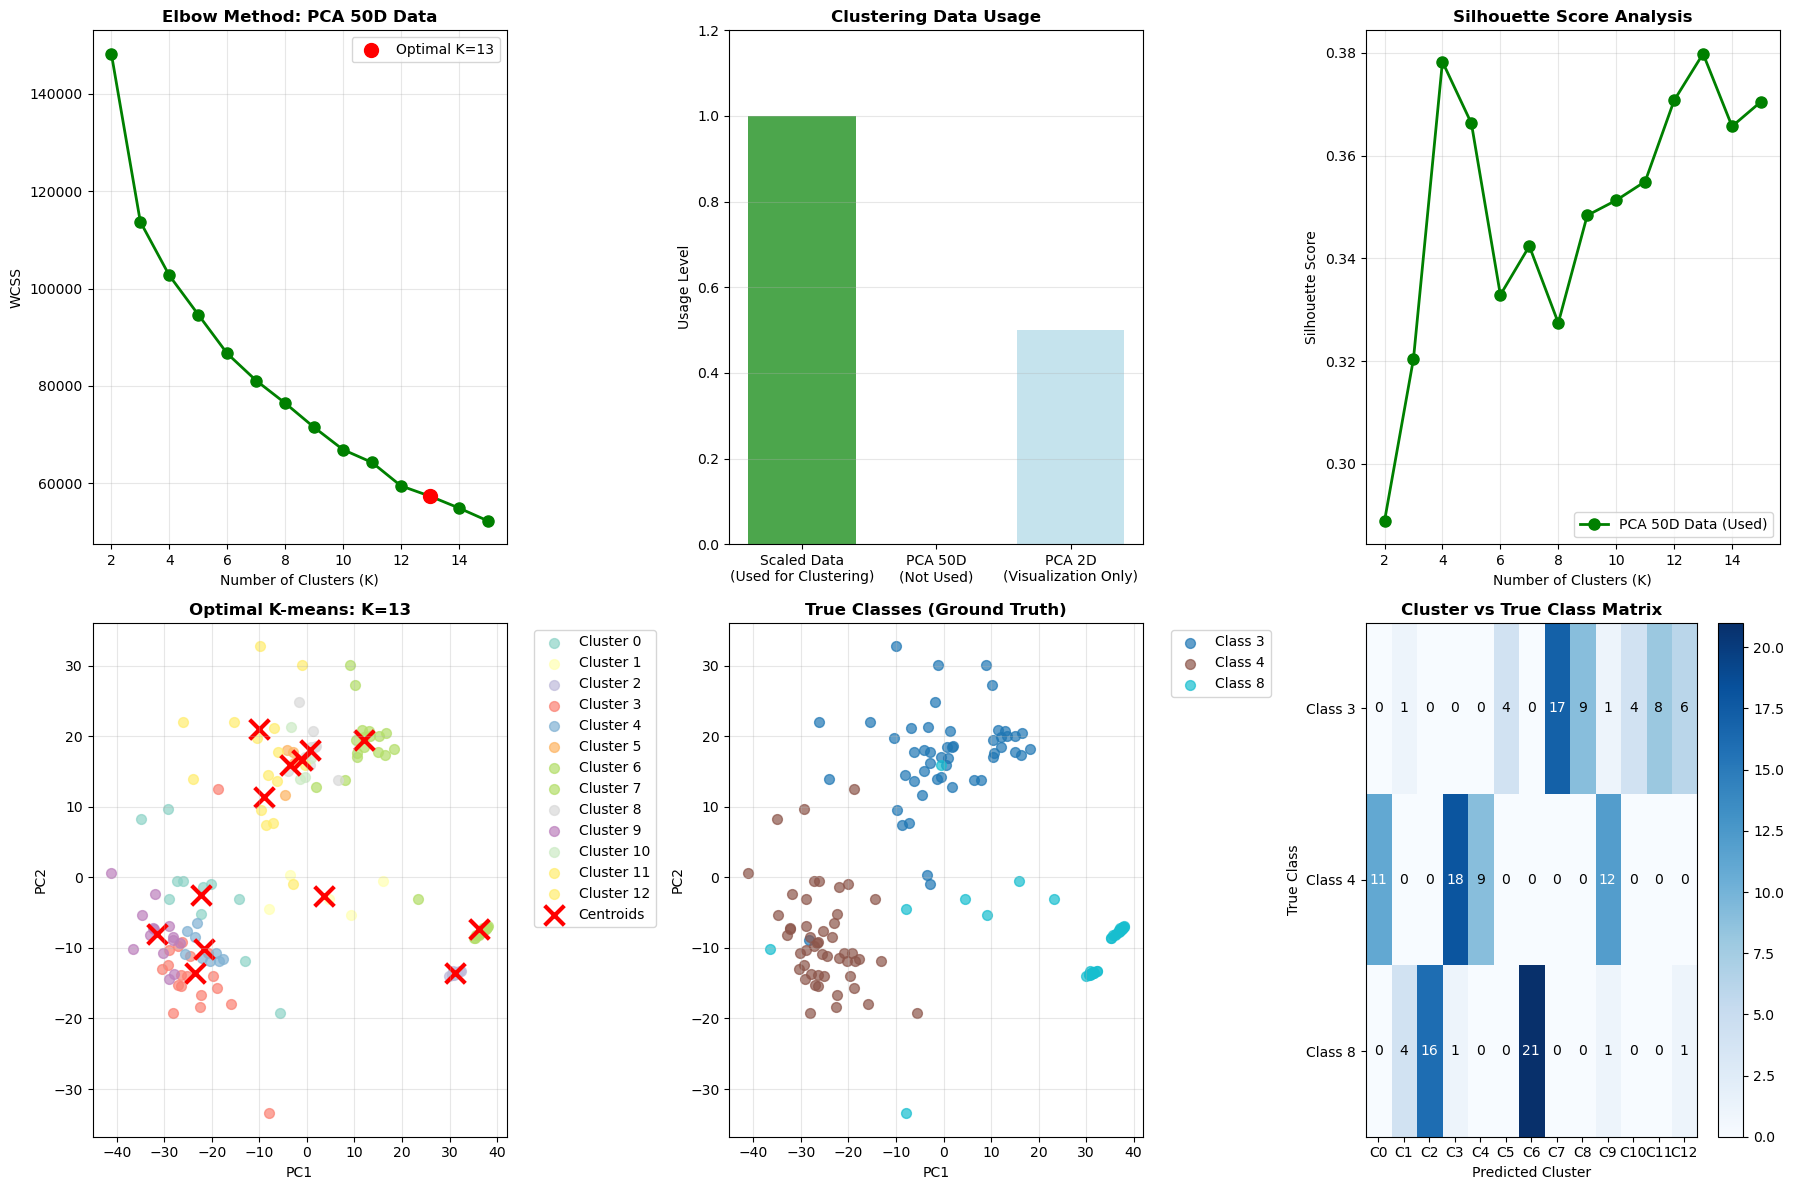

K-means PCA 50D visualization complete!
Note: Clustering performed on PCA 50D data, visualization in 2D PCA space


In [11]:
# ============================================================
# K-MEANS PCA 50D VISUALIZATION
# ============================================================

if "kmeans_results_pca" in locals() and kmeans_results_pca is not None:

    print("Creating K-means PCA 50D Analysis Visualizations...")

    # Create K-means analysis plots for PCA data
    visualizer.plot_kmeans_analysis(
        k_range=range(2, 16),
        results=kmeans_results_pca["elbow_analysis"],
        optimal_k_scaled=None,  # No scaled data in this analysis
        optimal_k_pca=kmeans_results_pca["optimal_k_pca"],
        X_pca_2d=clustering_data["X_pca_2d"],
        optimal_labels=kmeans_results_pca["optimal_labels"],
        centroids_2d=kmeans_results_pca["centroids_2d"],
        y_true=clustering_data["y_labels"],
        n_clusters=kmeans_results_pca["best_k"],
    )

    print("K-means PCA 50D visualization complete!")
    print("Note: Clustering performed on PCA 50D data, visualization in 2D PCA space")

else:
    print("K-means PCA results not available for visualization")
    print("   Please run the K-means PCA clustering cells first")

## 🎯 Mean Shift: Mode-Seeking Clustering

### Mean Shift's Unique Approach

**Centroid-Based**: Iteratively shifts cluster centers toward regions of higher density  
- Finds clusters without predefining their number  
- Works well for irregular or non-spherical clusters  

**Key Innovation**: Sliding window (kernel) moves toward data density peaks  
- Each point shifts toward the nearest high-density region (mode)  
- Automatically discovers the number of clusters  

**Parameters**:
- **Bandwidth**: Radius of the window (controls cluster granularity)


Mean Shift Clustering
📊 Creating Mean Shift Clustering Analysis & Comparison with Ground Truth
🔍 Available Mean Shift results: ['pca', 'normalized']

🔬 Computing metrics for PCA data...
📈 Mean Shift (PCA) Quality Metrics:
   • Clusters Found: 2
   • Ground Truth Classes: 3
   • Silhouette Score: 0.109
   • Adjusted Rand Index: 0.007
   • Normalized Mutual Info: 0.055
   • Homogeneity: 0.031
   • Completeness: 0.267
   • V-Measure: 0.055

🔬 Computing metrics for NORMALIZED data...
   ⚠️ Only 1 cluster(s) found - silhouette score not applicable
📈 Mean Shift (NORMALIZED) Quality Metrics:
   • Clusters Found: 1
   • Ground Truth Classes: 3
   • Silhouette Score: N/A (single cluster)
   • Adjusted Rand Index: 0.000
   • Normalized Mutual Info: 0.000
   • Homogeneity: 0.000
   • Completeness: 1.000
   • V-Measure: 0.000


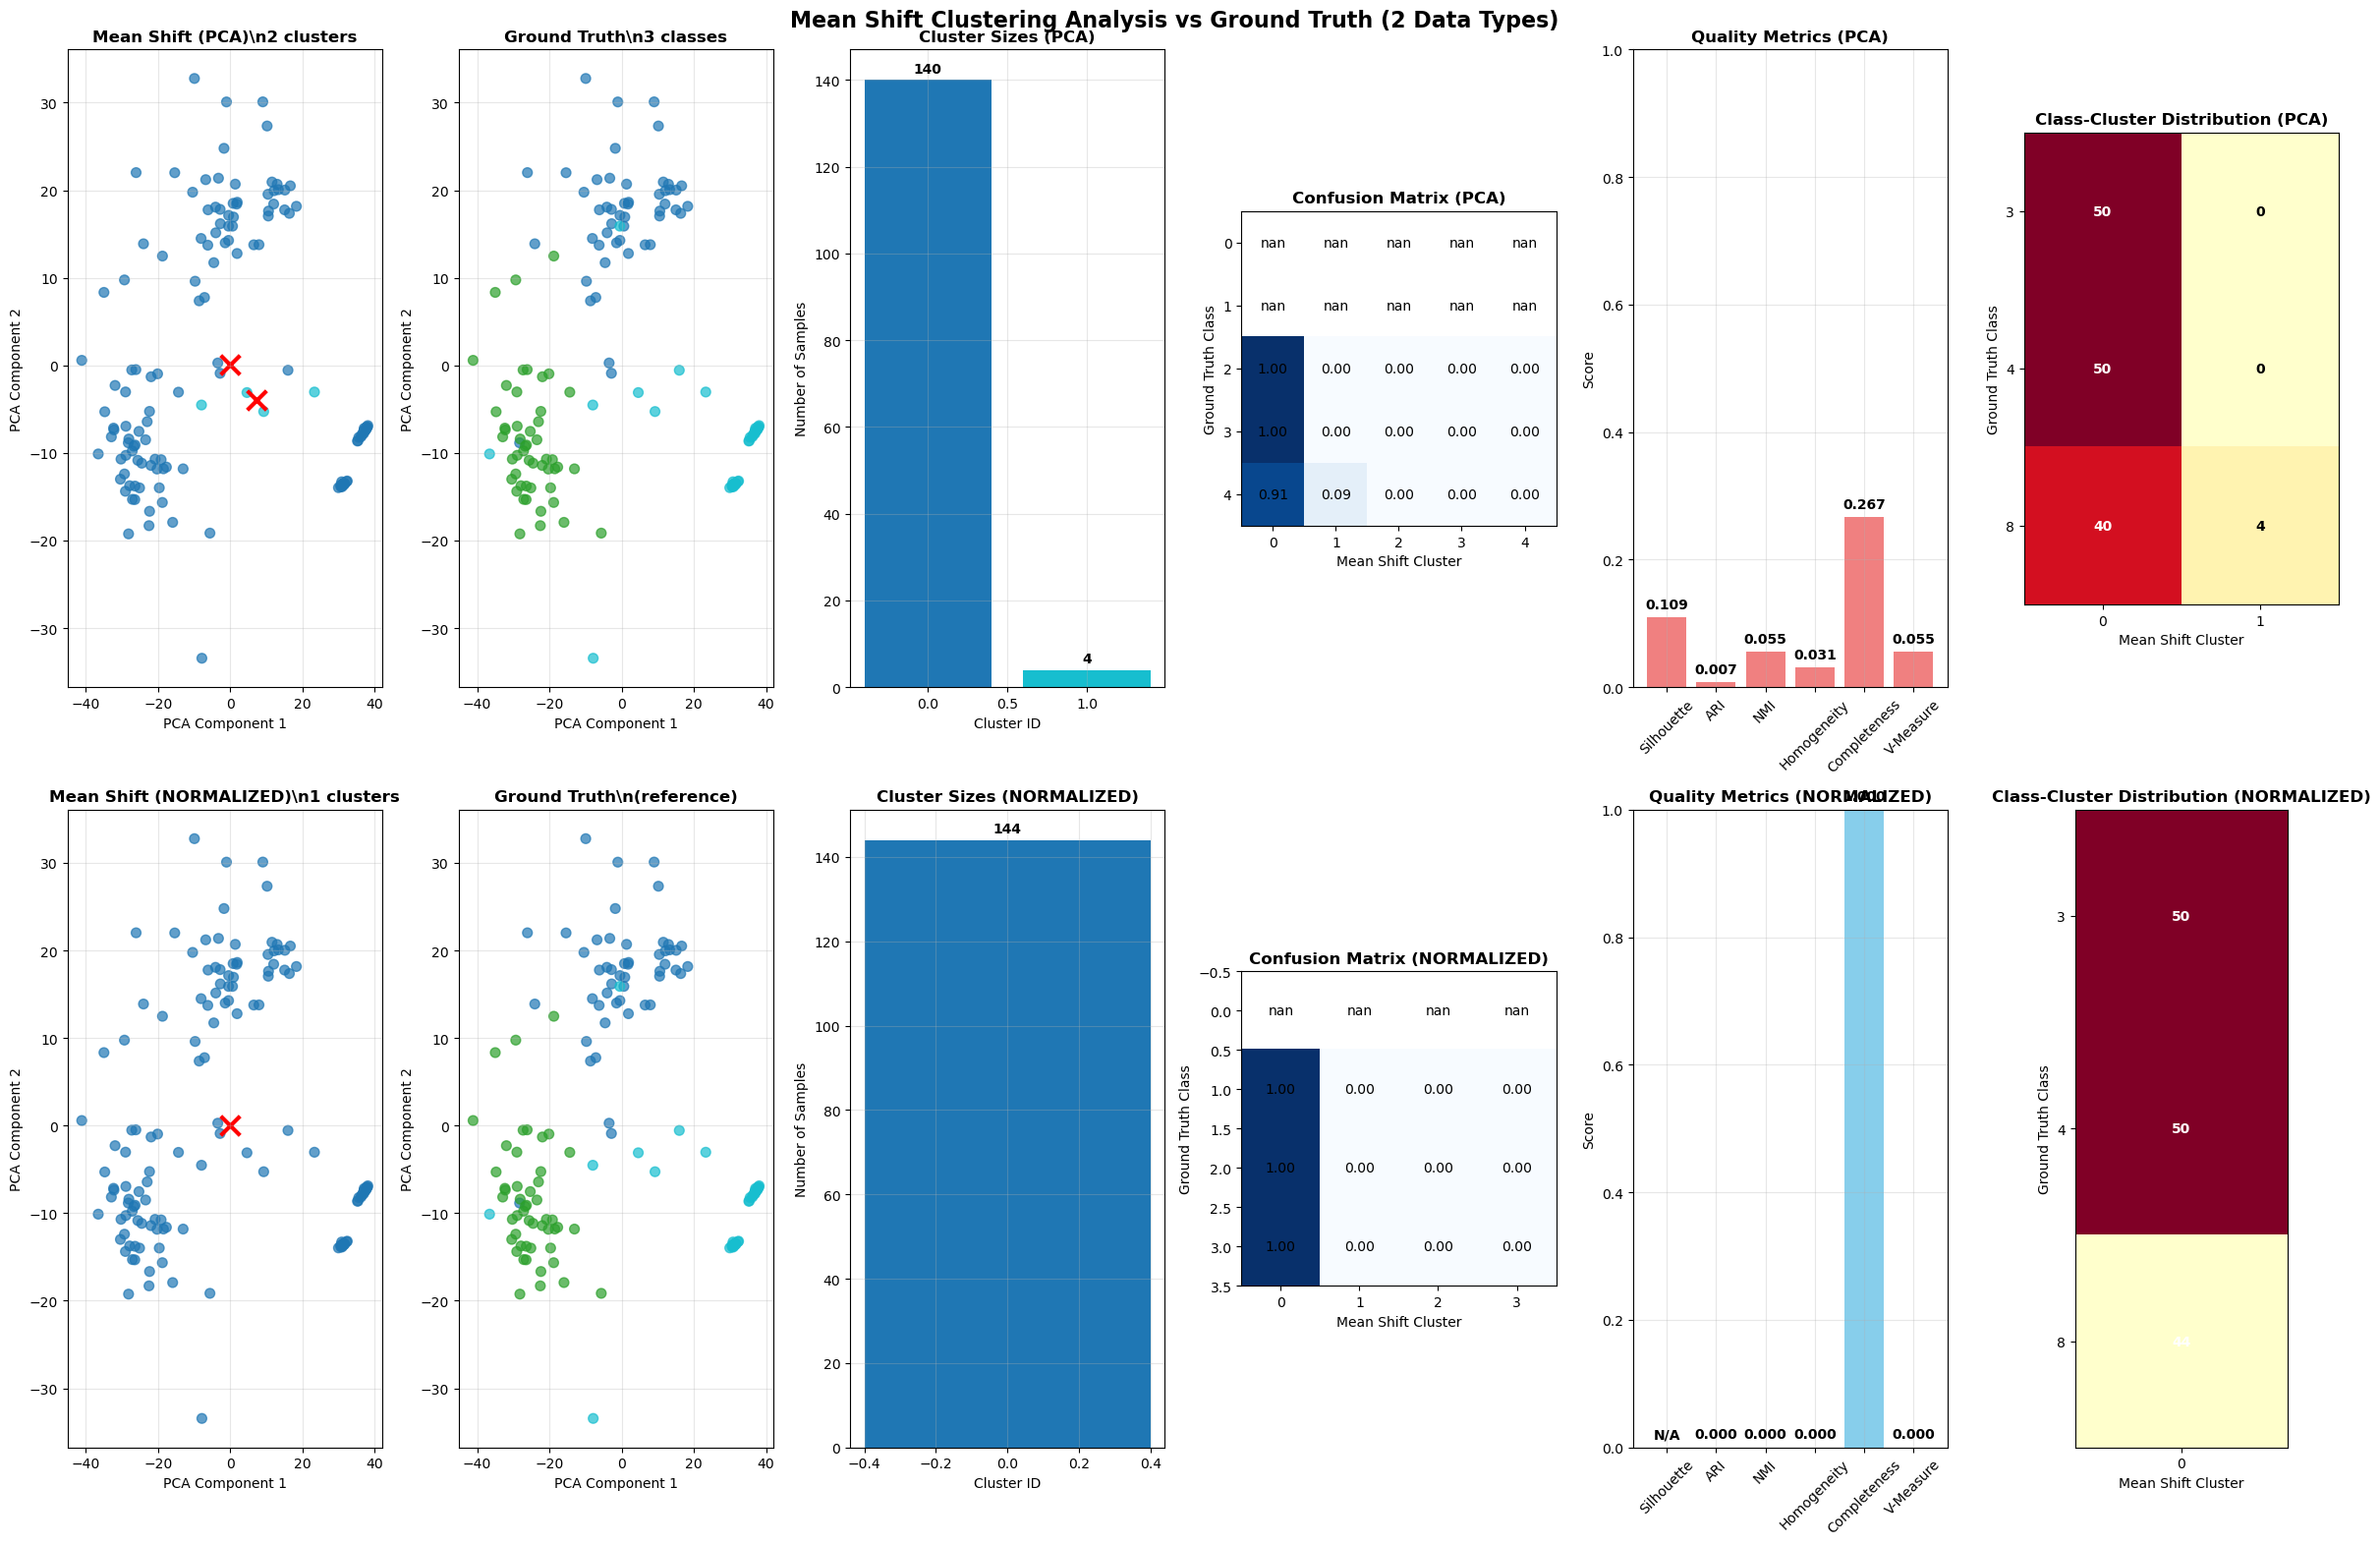


🎯 Mean Shift Clustering Comparison Summary:

📊 PCA Data Performance:
   • Clusters found: 2
   • Silhouette score: 0.109
   • Agreement with GT (ARI): 0.007
   ❌ Poor agreement with ground truth
   ❌ Poorly separated clusters

📊 NORMALIZED Data Performance:
   • Clusters found: 1
   • Silhouette score: N/A (single cluster)
   • Agreement with GT (ARI): 0.000
   ❌ Poor agreement with ground truth
   ⚠️ Cluster separation not applicable (single cluster)


In [12]:
# ============================================================
# MEAN SHIFT CLUSTERING
# ============================================================

# Import advanced clustering utilities
from src.clustering_utils import AdvancedClusteringAnalyzer

# Extract data for clustering
X_normalized = clustering_data["X_normalized"]
X_pca_50 = clustering_data["X_pca_50"]
X_pca_2d = clustering_data["X_pca_2d"]
y_true = clustering_data["y_labels"]

# Initialize advanced clustering analyzer
advanced_analyzer = AdvancedClusteringAnalyzer()

# Run Mean Shift clustering
meanshift_results = advanced_analyzer.run_mean_shift(X_pca_50, X_normalized)


# Use the extracted visualization method for clean, maintainable code
visualizer.plot_meanshift_analysis(
    meanshift_results=meanshift_results, clustering_data=clustering_data
)

## 🎯 DBSCAN: Density-Based Clustering

### DBSCAN's Unique Approach

**Density-Based**: Groups points in high-density regions, marks sparse areas as noise
- Perfect for real-world data with outliers
- Can find arbitrary cluster shapes (not just spherical)

**Key Innovation**: Automatic noise detection
- Points in low-density areas labeled as "noise"
- Robust to outliers and irregular patterns

**Parameters**:
- **ε (eps)**: Maximum distance for neighborhood
- **MinPts**: Minimum points to form a dense cluster

DBSCAN Clustering

DBSCAN Normalized Results:
   • Best eps: 6.7947
   • Best min_samples: 8
   • Clusters found: 2
   • Noise points: 108
   • Silhouette score: 0.341
DBSCAN Clustering

DBSCAN PCA 50D Results:
   • Best eps: 18.7310
   • Best min_samples: 8
   • Clusters found: 2
   • Noise points: 108
   • Silhouette score: 0.345

🎯 Running DBSCAN Comprehensive Analysis...
📊 Creating DBSCAN Clustering Analysis & Comparison with Ground Truth
🔍 Available DBSCAN results: ['normalized', 'pca']

🔬 Computing metrics for NORMALIZED data...
   • Parameters: eps=6.7947, min_samples=8
   • Clusters found: 2
   • Noise points: 108
📈 DBSCAN (NORMALIZED) Quality Metrics:
   • Clusters Found: 2
   • Noise Points: 108
   • Ground Truth Classes: 3
   • Silhouette Score: 0.944
   • Adjusted Rand Index: 0.285
   • Normalized Mutual Info: 0.456
   • Homogeneity: 0.381
   • Completeness: 0.569
   • V-Measure: 0.456

🔬 Computing metrics for PCA data...
   • Parameters: eps=18.7310, min_samples=8
   • Clu

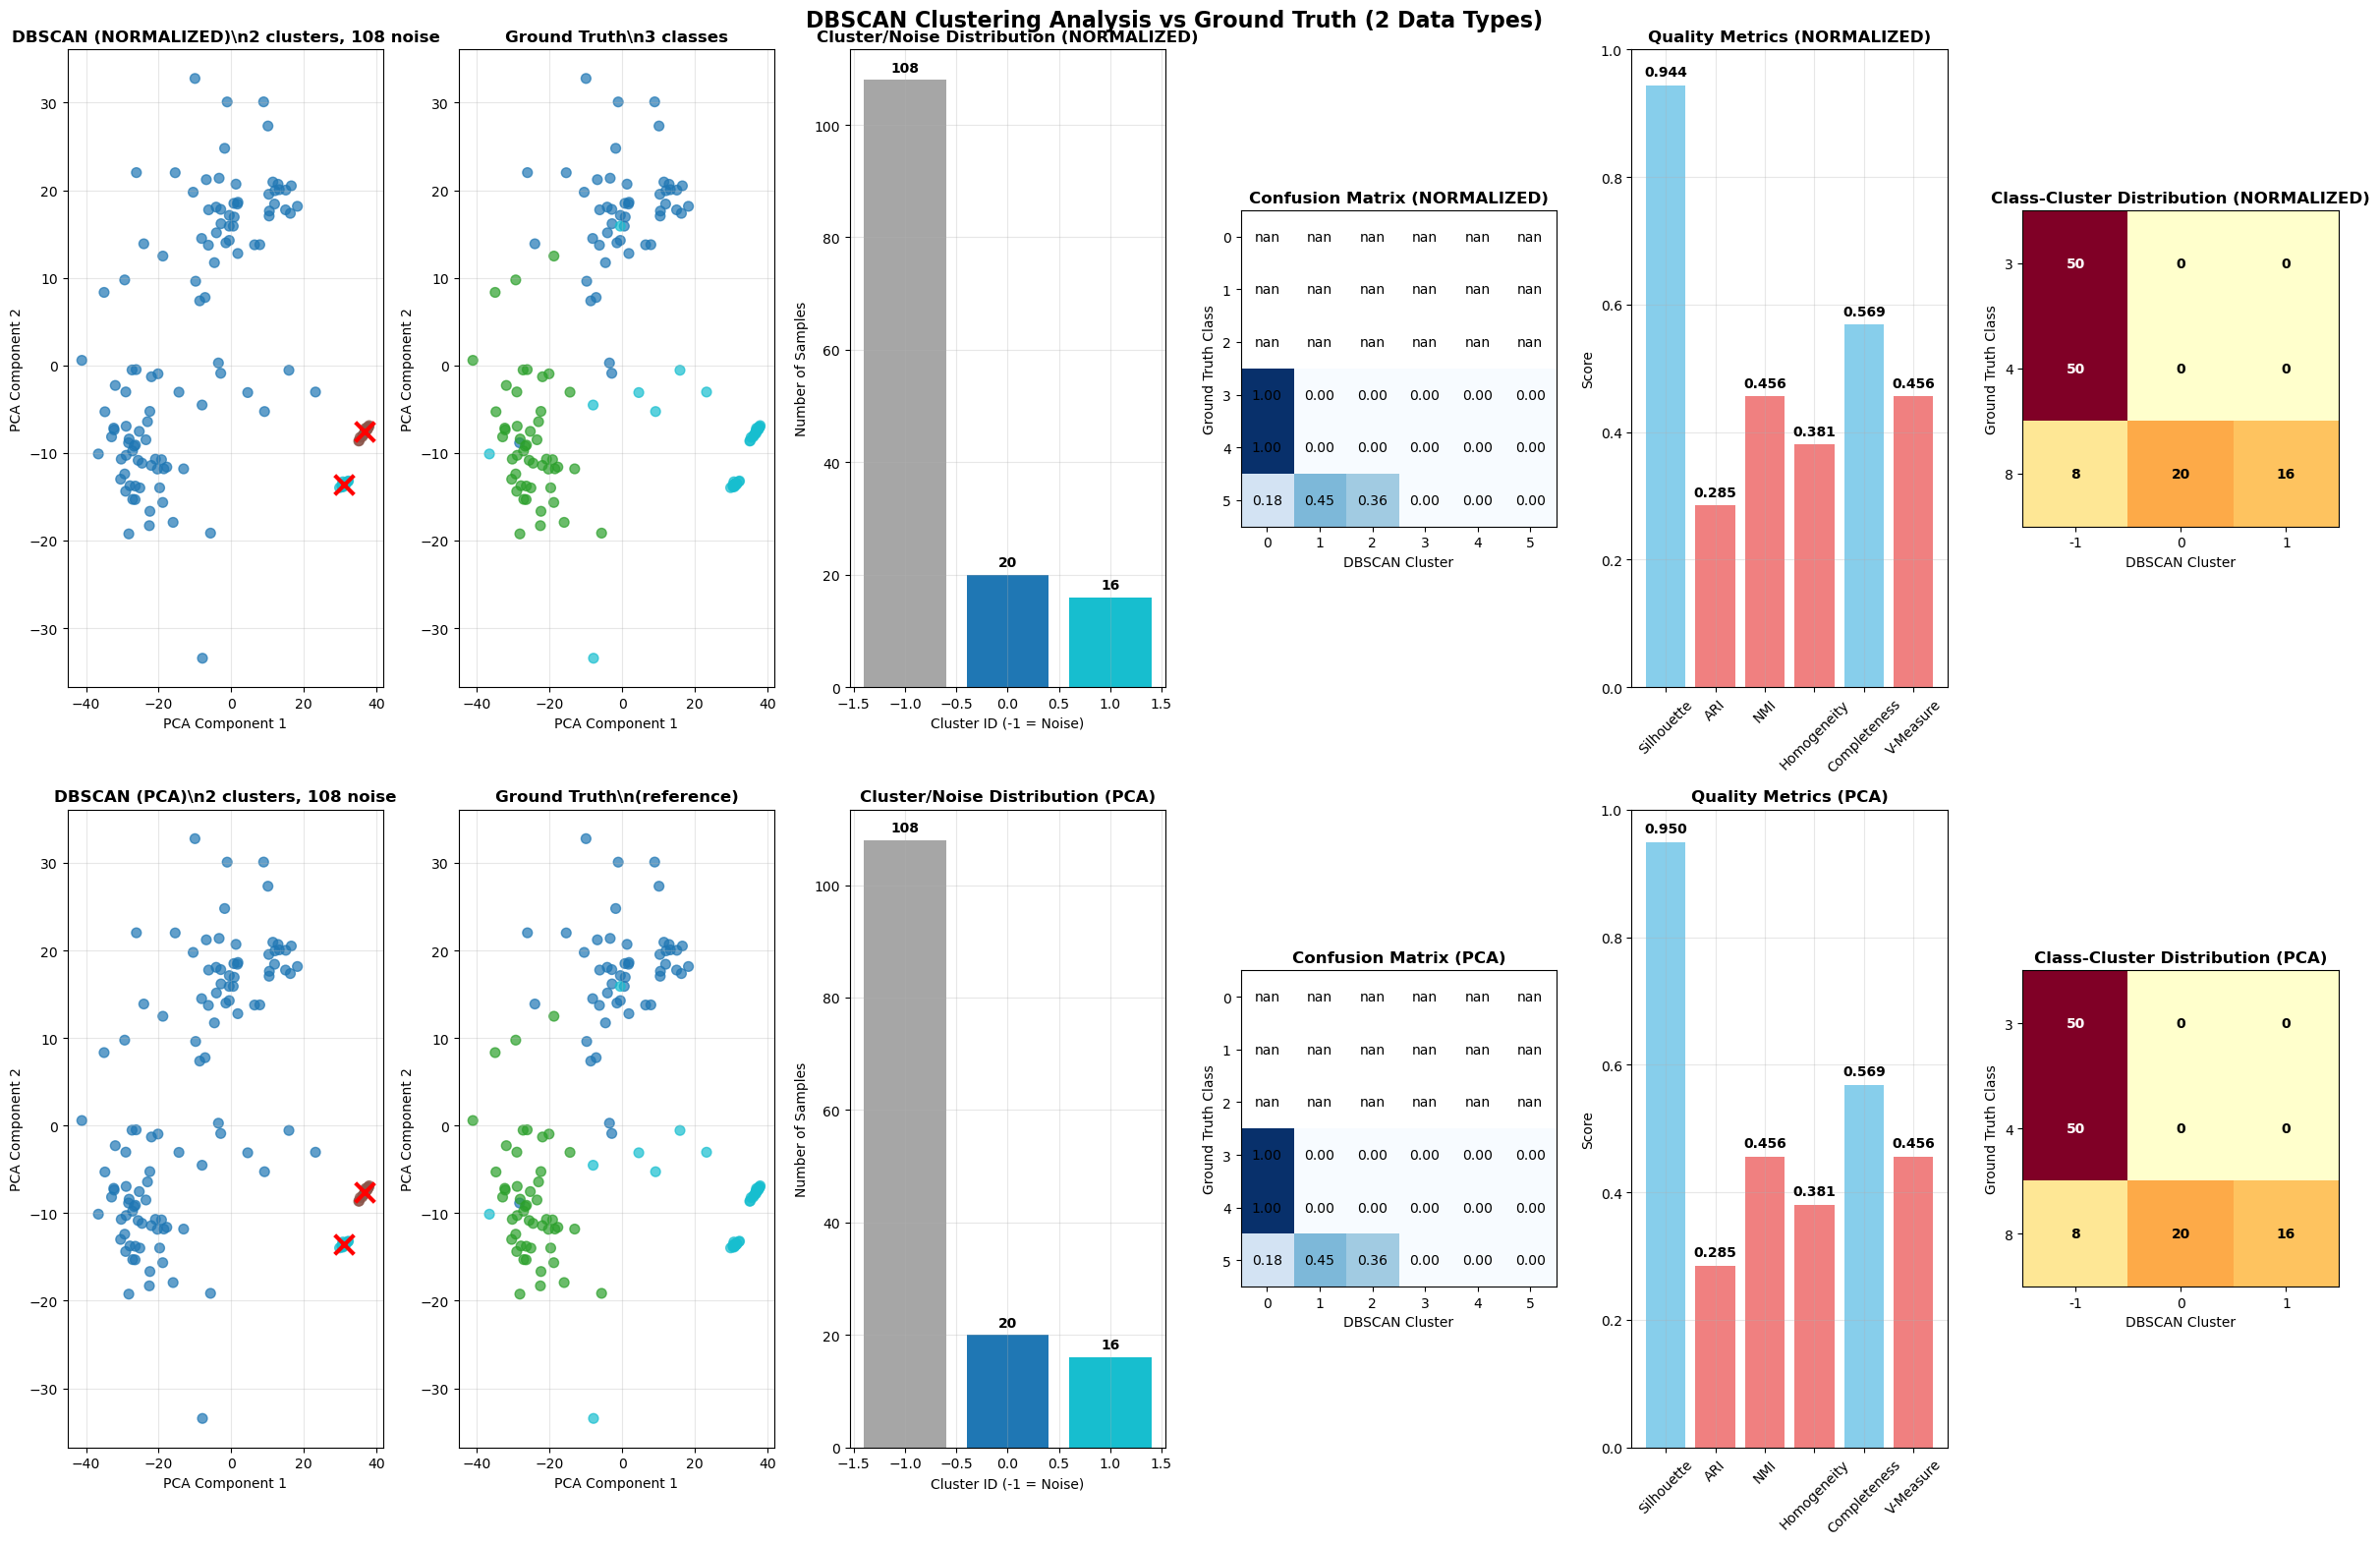


🎯 DBSCAN Clustering Comparison Summary:

📊 NORMALIZED Data Performance:
   • Clusters found: 2
   • Noise points: 108 (75.0%)
   • Silhouette score: 0.944
   • Agreement with GT (ARI): 0.285
   ⚠️ Moderate agreement with ground truth
   ✅ Well-separated clusters
   ⚠️ High noise ratio - consider adjusting eps or min_samples

📊 PCA Data Performance:
   • Clusters found: 2
   • Noise points: 108 (75.0%)
   • Silhouette score: 0.950
   • Agreement with GT (ARI): 0.285
   ⚠️ Moderate agreement with ground truth
   ✅ Well-separated clusters
   ⚠️ High noise ratio - consider adjusting eps or min_samples

✅ DBSCAN analysis complete!
📊 Comparison shows performance on both normalized and PCA 50D data


In [13]:
# ============================================================
# DBSCAN CLUSTERING
# ============================================================

# Run DBSCAN clustering with parameter optimization
dbscan_results = advanced_analyzer.run_dbscan(X_normalized)

if dbscan_results is not None:
    print(f"\nDBSCAN Normalized Results:")
    print(f"   • Best eps: {dbscan_results['params']['eps']:.4f}")
    print(f"   • Best min_samples: {dbscan_results['params']['min_samples']}")
    print(f"   • Clusters found: {dbscan_results['n_clusters']}")
    print(f"   • Noise points: {dbscan_results['n_noise']}")
    print(f"   • Silhouette score: {dbscan_results['silhouette']:.3f}")

# Run DBSCAN clustering with parameter optimization PCA
dbscan_results_PCA = advanced_analyzer.run_dbscan(X_pca_50)

if dbscan_results_PCA is not None:
    print(f"\nDBSCAN PCA 50D Results:")
    print(f"   • Best eps: {dbscan_results_PCA['params']['eps']:.4f}")
    print(f"   • Best min_samples: {dbscan_results_PCA['params']['min_samples']}")
    print(f"   • Clusters found: {dbscan_results_PCA['n_clusters']}")
    print(f"   • Noise points: {dbscan_results_PCA['n_noise']}")
    print(f"   • Silhouette score: {dbscan_results_PCA['silhouette']:.3f}")

print("\n" + "=" * 60)
print("🎯 Running DBSCAN Comprehensive Analysis...")

# Use the extracted visualization method for clean, maintainable code
visualizer.plot_dbscan_analysis(
    dbscan_results_norm=dbscan_results,
    dbscan_results_pca=dbscan_results_PCA,
    clustering_data=clustering_data,
)

print("\n✅ DBSCAN analysis complete!")
print("📊 Comparison shows performance on both normalized and PCA 50D data")

---

# 🚀 Advanced Clustering Section

## Enhanced Algorithm Implementations & Interactive Visualizations

*This section provides advanced clustering techniques and enhanced visualizations for deeper analysis.*

## 📊 Clustering Performance Evaluation

### How to Measure Clustering Quality

**Challenge**: No single "correct" clustering - it's subjective!

**Internal Metrics** (no ground truth needed):
- **Silhouette Score**: Measures cluster separation and cohesion
- **Within-cluster sum of squares**: Tightness of clusters

**External Metrics** (compare against known labels):
- **Adjusted Rand Index (ARI)**: Measures agreement with true classes
- **Accuracy**: After optimal cluster-to-class assignment

**Business Context**: Best metric depends on your goal
- Pattern discovery vs known class validation

### Beyond Basic Algorithms

**Enhanced Methods**: More sophisticated versions of standard algorithms
- **Enhanced K-means**: Better initialization and convergence
- **Gaussian Mixture Models**: Probabilistic clustering with soft assignments
- **Hierarchical Clustering**: Tree-based cluster discovery
- **Optimized DBSCAN**: Automatic parameter tuning

**Why Advanced Methods?**
- Better handling of complex data patterns
- More robust parameter selection
- Improved clustering quality for industrial data

In [14]:
# ============================================================
# ADVANCED ALGORITHM IMPLEMENTATIONS
# ============================================================

# Import advanced clustering utilities
from src.clustering_utils import AdvancedClusteringSuite

# Initialize advanced clustering suite
if "clustering_data" in locals() and clustering_data is not None:
    print("Initializing Advanced Clustering Suite...")

    advanced_suite = AdvancedClusteringSuite()

    # Run advanced clustering with multiple algorithms
    advanced_results = advanced_suite.run_advanced_clustering_suite(
        X_data=clustering_data["X_pca_50"], y_true=clustering_data["y_labels"], max_k=8
    )

    print(f"\n📊 Advanced clustering results available for visualization!")

else:
    print("❌ Clustering data not available. Run previous cells first.")
    advanced_results = None

Initializing Advanced Clustering Suite...
🔬 Advanced Clustering Suite
1. Enhanced K-means with K-means++
   ✓ Best K: 4, Silhouette: 0.378
2. Gaussian Mixture Models (GMM)
   ✓ Best Components: 3, Silhouette: 0.320
3. Hierarchical Clustering (Multiple Linkages)
   ✓ Best: 4 clusters, ward linkage
     Silhouette: 0.381
4. Optimized DBSCAN with Grid Search
   ✓ Best: eps=31.995, min_samples=3
     Clusters: 7, Noise: 20
     Silhouette: 0.358

🏆 Advanced Clustering Complete!

📊 Advanced clustering results available for visualization!


Creating Advanced Clustering Comparison Visualization...
🎨 Creating Advanced Visualizations
1. Multi-Algorithm Comparison Dashboard


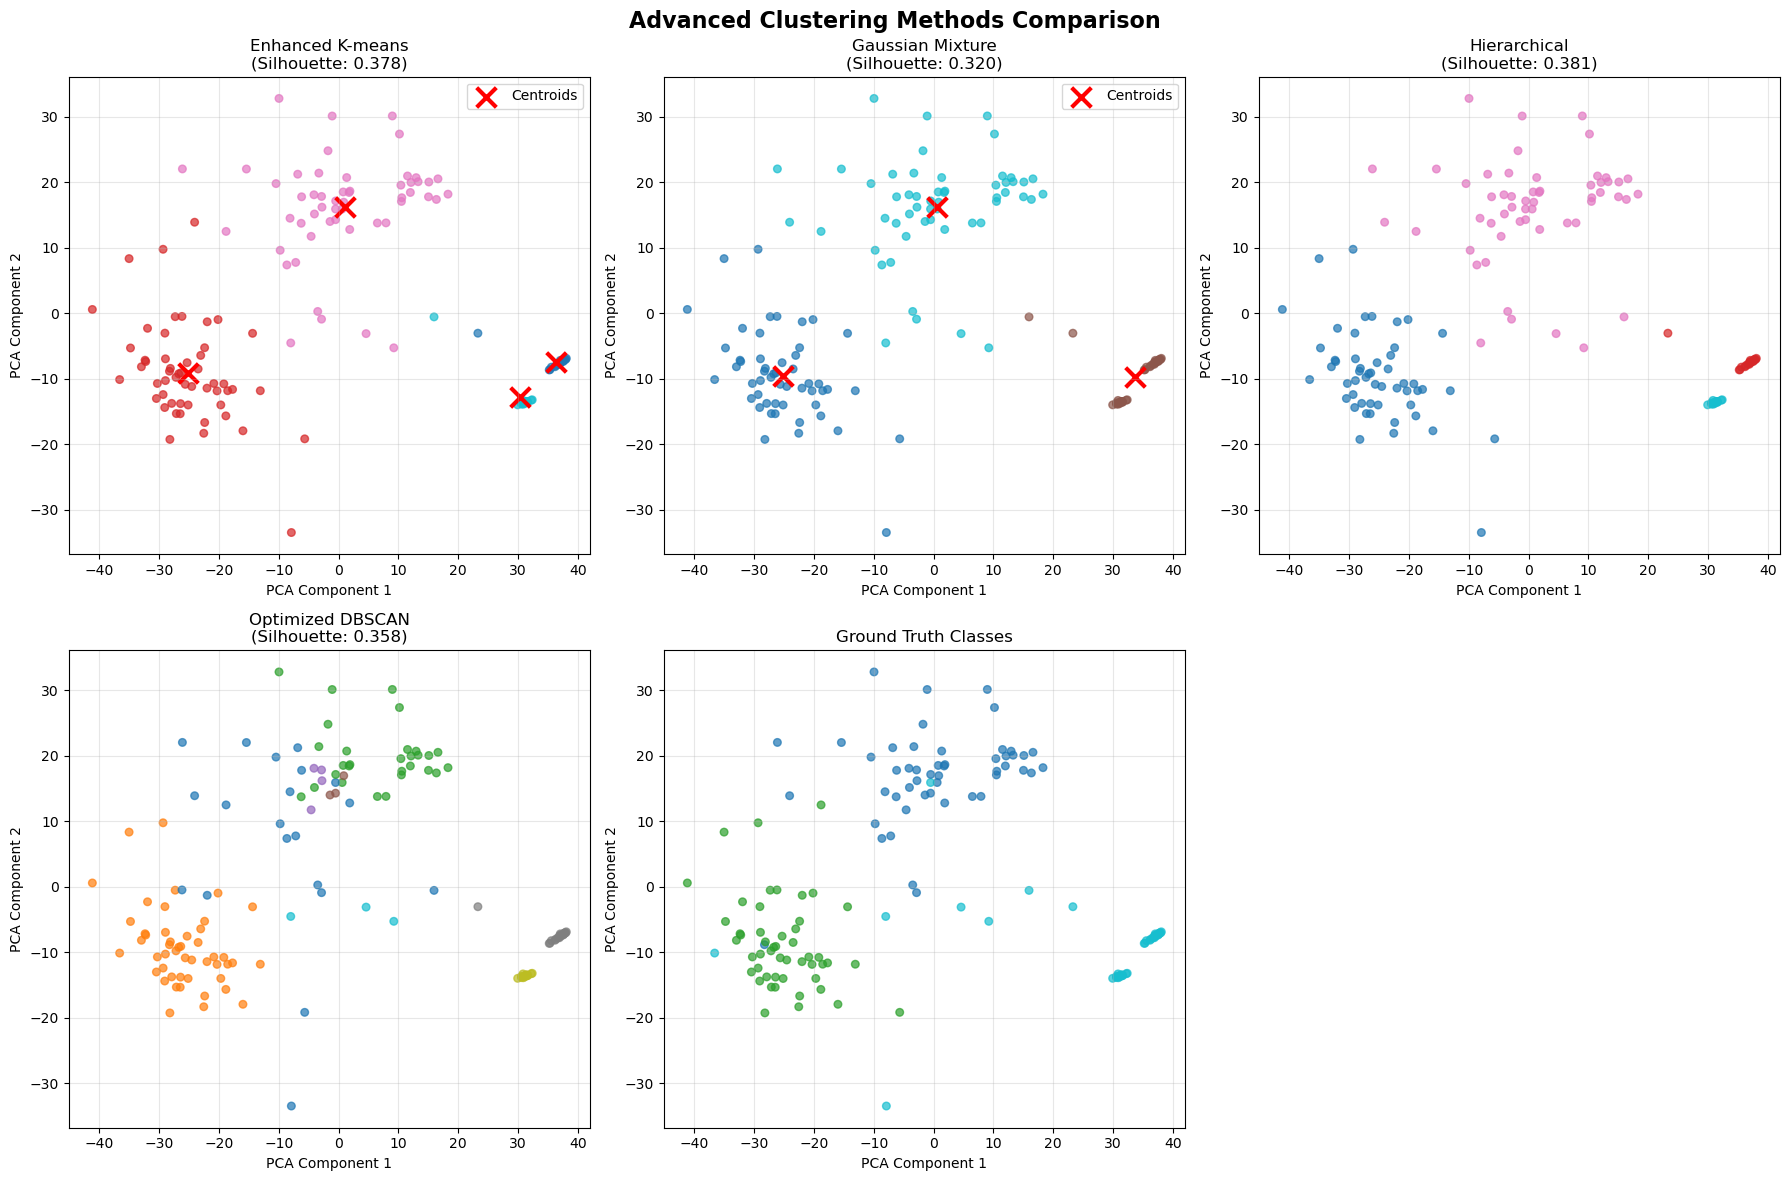


🎨 Advanced Visualizations Complete!


In [15]:
# ============================================================
# ADVANCED VISUALIZATION: CLUSTER COMPARISON WITH CENTERS
# ============================================================

# Import advanced visualization utilities
from src.clustering_visualization import AdvancedClusteringVisualizer

if advanced_results is not None and "clustering_data" in locals():
    print("Creating Advanced Clustering Comparison Visualization...")

    # Initialize advanced visualizer
    advanced_visualizer = AdvancedClusteringVisualizer()

    # Create comprehensive advanced visualizations showing cluster centers and ground truth
    advanced_visualizer.create_advanced_visualizations(
        clustering_data=clustering_data,
        advanced_results=advanced_results,
        original_results=(
            {"kmeans": kmeans_results} if "kmeans_results" in locals() else None
        ),
    )

else:
    print("❌ Advanced results not available. Run the advanced clustering cell first.")

### **Hungarian Algorithm for Clustering Accuracy**

**Problem**: How to fairly compare clustering results with ground truth when cluster labels are arbitrary?

**Solution**: The **Hungarian Algorithm** finds the optimal assignment between predicted clusters and true classes.

**Mathematical Foundation:**

Given a **cost matrix** $C$ where $C_{ij}$ represents the cost of assigning true class $i$ to predicted cluster $j$:

$$\text{Minimize: } \sum_{i,j} C_{ij} \cdot x_{ij}$$

Subject to:
- $\sum_j x_{ij} = 1$ (each true class assigned to exactly one cluster)
- $\sum_i x_{ij} = 1$ (each cluster assigned to exactly one true class)  
- $x_{ij} \in \{0,1\}$ (binary assignment)

**For Clustering Accuracy:**
- $C_{ij} = -\text{count}_{ij}$ (negative because we want to **maximize** matches)
- $\text{count}_{ij}$ = number of samples with true class $i$ in predicted cluster $j$

**Algorithm Steps:**
1. **Build confusion matrix**: Count samples for each (true_class, predicted_cluster) pair
2. **Apply Hungarian algorithm**: Find optimal assignment that maximizes total matches
3. **Calculate accuracy**: $\text{Accuracy} = \frac{\text{Total Optimal Matches}}{\text{Total Samples}}$

**Why Use This?**
- **Fair comparison**: Handles arbitrary cluster labels (cluster 0 might correspond to class 3)
- **Optimal assignment**: Guarantees best possible accuracy for any label permutation
- **Robust metric**: Works even when number of clusters ≠ number of true classes

In [16]:
# ============================================================
# CLUSTERING ACCURACY EVALUATION
# ============================================================

# Import the evaluation function
from src.clustering_utils import evaluate_clustering_accuracy

if advanced_results is not None and "clustering_data" in locals():
    # Prepare clustering results for evaluation
    evaluation_methods = {}

    # Add advanced clustering results
    for method_key, method_result in advanced_results.items():
        if method_result is not None:
            evaluation_methods[method_key.replace("_", " ").title()] = method_result

    # Add K-means results (scaled)
    if "kmeans_results" in locals() and kmeans_results is not None:
        evaluation_methods["K-means (Scaled)"] = kmeans_results

    # Add K-means PCA results
    if "kmeans_results_pca" in locals() and kmeans_results_pca is not None:
        evaluation_methods["K-means (PCA 50D)"] = kmeans_results_pca

    # Run comprehensive accuracy evaluation
    accuracy_results = evaluate_clustering_accuracy(
        y_true=clustering_data["y_labels"], clustering_results=evaluation_methods
    )

    print(f"\n🎯 Evaluation complete! {len(accuracy_results)} methods evaluated.")

else:
    print("❌ Advanced results not available. Run the advanced clustering cell first.")

🎯 Evaluating Clustering Accuracy Against Ground Truth
📊 Clustering Method Accuracy Results:
--------------------------------------------------
   • Enhanced Kmeans          : 0.819 (81.9%) | Clusters: 4
   • Gmm                      : 0.944 (94.4%) | Clusters: 3
   • Hierarchical             : 0.826 (82.6%) | Clusters: 4
   • Optimized Dbscan         : 0.667 (66.7%) | Clusters: 8
   • K-means (Scaled)         : 0.819 (81.9%) | Clusters: 4
   • K-means (PCA 50D)        : 0.389 (38.9%) | Clusters: 13

🏆 Best Performing Method: Gmm (94.4%)
📊 Ground Truth Classes: 3 | Total Samples: 144

✅ Accuracy evaluation complete!

🎯 Evaluation complete! 6 methods evaluated.


🎨 Running Complete Clustering Analysis Visualization Suite
🎨 Running Complete Clustering Analysis Visualization Suite
📊 1. Generating Data Overview...


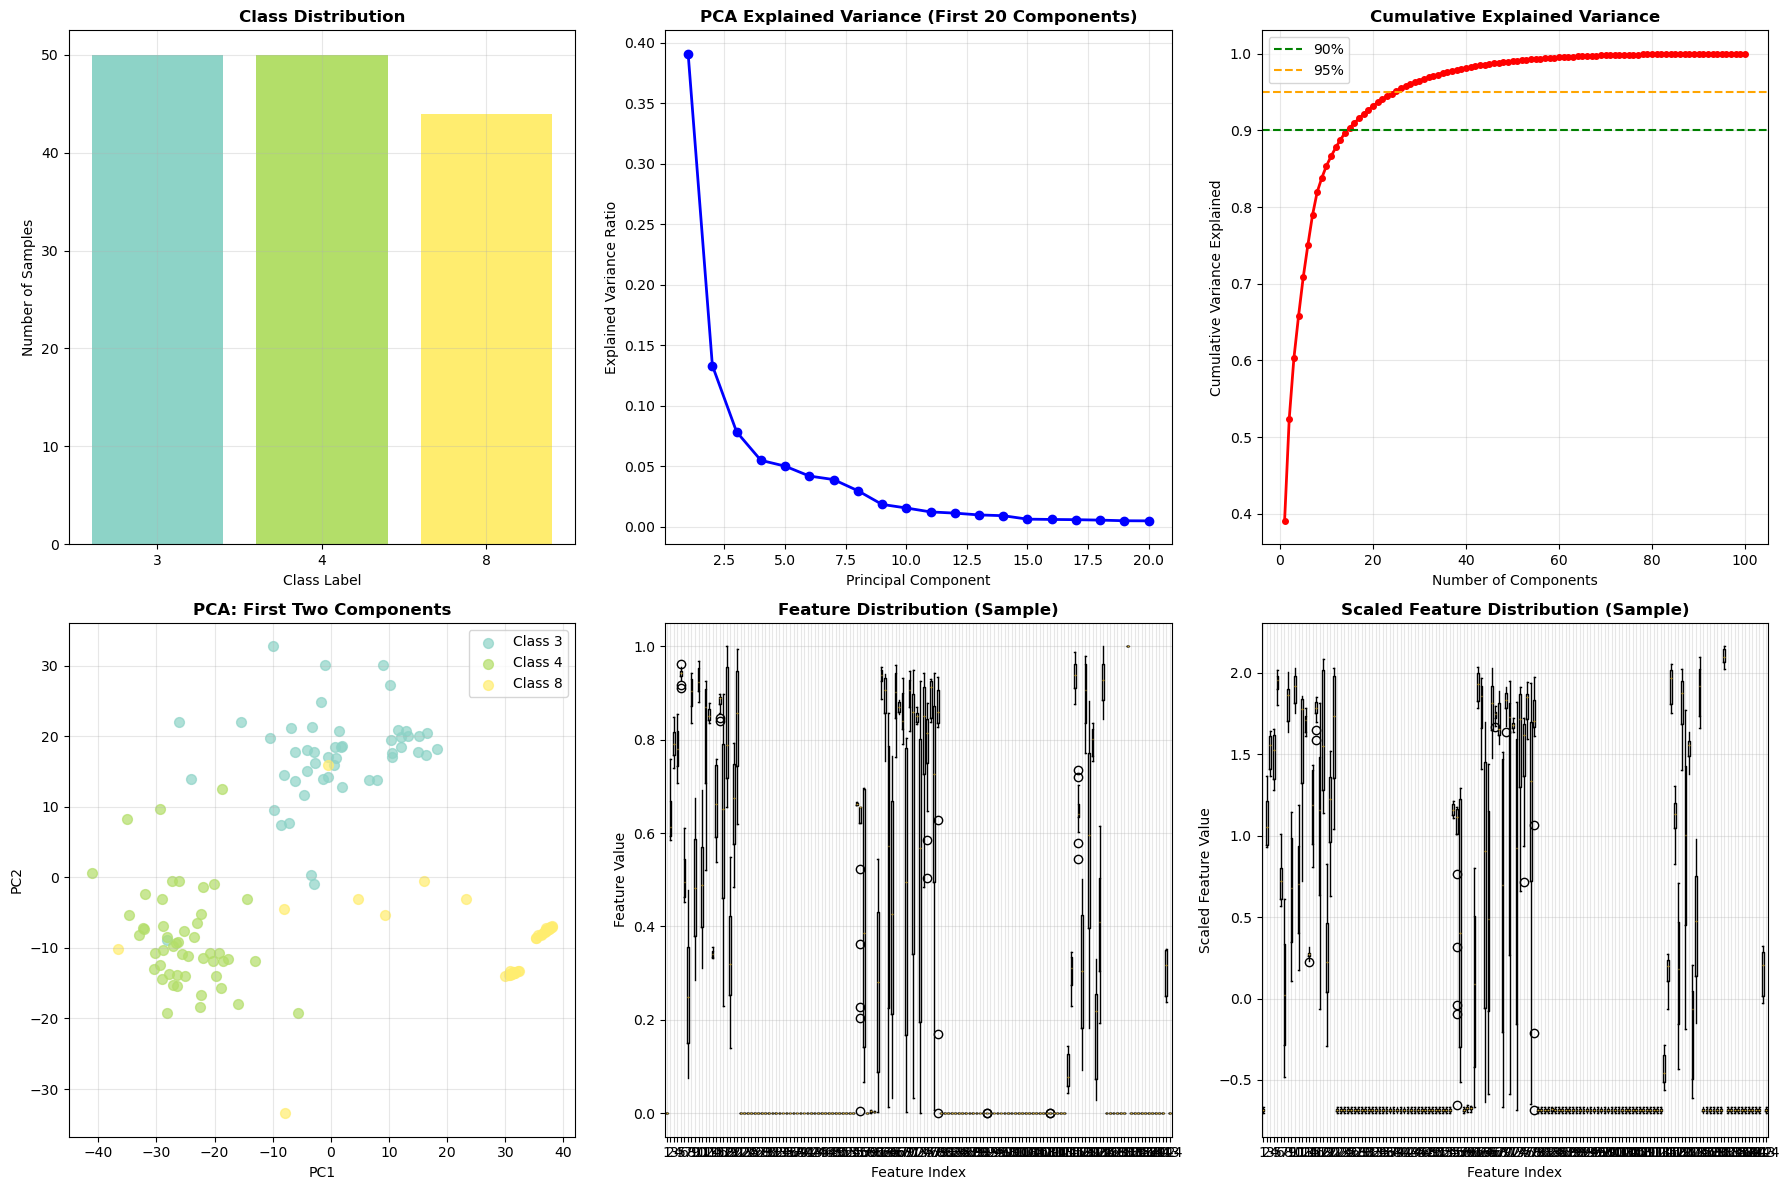

🎯 2. Generating K-means Analysis Plots...
   ⚠️ K-means visualization error: ClusteringVisualizer.plot_kmeans_analysis() got an unexpected keyword argument 'clustering_data'
📈 4. Generating Performance Summary...


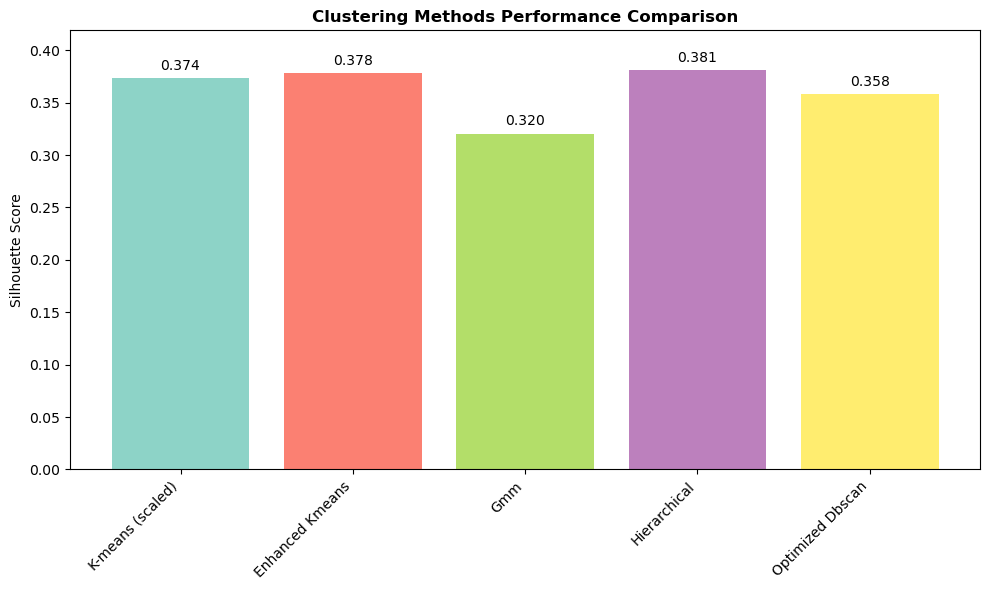

🎯 5. Generating Accuracy Summary...


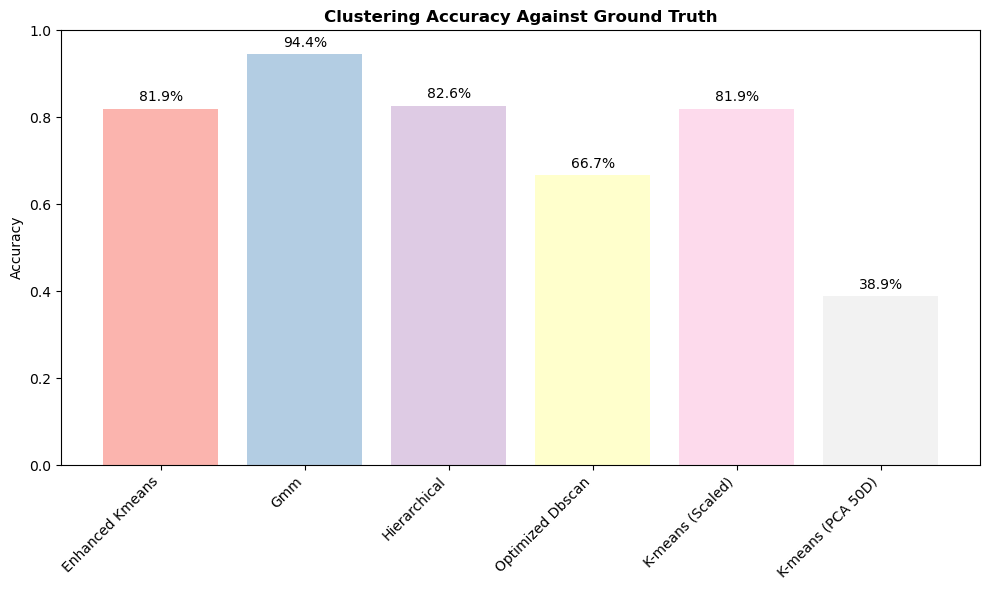


🎉 Visualization Suite Complete!
   📊 Generated 3 visualization(s)
-----------------------------------------------------------------


In [17]:
# ============================================================
# COMPLETE CLUSTERING ANALYSIS VISUALIZATION SUITE
# ============================================================

print("🎨 Running Complete Clustering Analysis Visualization Suite")
print("=" * 65)

# Use the extracted visualization orchestration method
visualizer.clustering_analysis_suite(
    clustering_data=clustering_data,
    kmeans_results=kmeans_results,  # Scaled K-means results
    advanced_results=advanced_results,
    accuracy_results=accuracy_results if "accuracy_results" in locals() else None,
)